# Extracting and Plotting Position-Velocity Diagrams

## Authors
Adam Ginsburg, Eric Koch

## Learning Goals
* Extract a position-velocity diagram from a spectral cube using both pixel and sky coordinates using [pvextractor](https://pvextractor.readthedocs.io/en/latest/)
* Display the position-velocity diagram with appropriately labeled coordinates
* Display the extraction path on the plots

## Keywords
pv-diagram, spectral cube, pvextractor, radio astronomy, coordinates

## Summary
In this tutorial, we will extract position-velocity (PV) diagrams from a spectral cube and plot them.

Position-velocity diagrams are often used in radio astronomy for analysis of rotating objects, like protostellar disks and galaxies, to measure rotation curves and determine the contained mass.  They are also used in studies of atomic and molecular clouds to show where overlapping emission may point at interactions between distinct clouds.  Both radio and optical position-velocity diagrams are used to study outflows, jets, and winds; in the optical, two-dimensional spectra obtained from long-slit spectrographs naturally produce the equivalent of a position-velocity diagram.

### Header material

We import tools from several packages up front:

In [1]:
import pylab as pl
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs

# set so that these display properly on black backgrounds
pl.rcParams['figure.facecolor']='w'

from spectral_cube import SpectralCube

from pvextractor import extract_pv_slice, Path

Retrieve and open a cube from astropy-data:

In [2]:
cube = SpectralCube.read('http://www.astropy.org/astropy-data/l1448/l1448_13co.fits')
cube

SpectralCube with shape=(53, 105, 105):
 n_x:    105  type_x: RA---SFL  unit_x: deg    range:    50.924417 deg:   51.740103 deg
 n_y:    105  type_y: DEC--SFL  unit_y: deg    range:    30.301945 deg:   30.966389 deg
 n_s:     53  type_s: VOPT      unit_s: m / s  range:     2528.195 m / s:    5982.223 m / s

We show a single channel from the cube to visualize the data spatially.
We use pixel units to start; we'll show celestial coordinates later

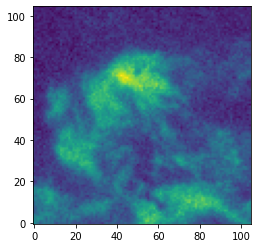

In [3]:
pl.imshow(cube[25].value, origin='lower')

# PV Extraction from Pixel Coordinates

First we create an extraction _path_.
This path is the two-dimensional spatial coordinates through which we are cutting out our PV diagram.
It is drawn below.

The entries are pairs of pixel coordinates, (x,y).  In this case, we've selected arbitrary coordinates for our demonstration, but for your use case, you might pick the axis of an outflow, the major axis of an inclined disk, or a spiral following an arm of a galaxy.

In [4]:
path = Path([(20,20), (40,40), (60,20)])

Then we can overplot it on our figure, now with WCS shown.  The plotting uses [WCSAxes](https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html)

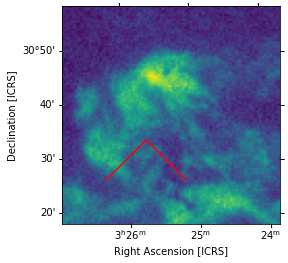

In [5]:
ax = pl.subplot(111, projection=cube.wcs.celestial)
ax.imshow(cube[25].value)
path.show_on_axis(ax, spacing=1, color='r')
ax.set_xlabel(f"Right Ascension [{cube.wcs.wcs.radesys}]")
ax.set_ylabel(f"Declination [{cube.wcs.wcs.radesys}]")

`spacing` gives the separation between these points in pixels; we finely sampled by picking one-pixel spacing.

We can then extract the pv diagram, specifying the same spacing.

In [6]:
pvdiagram = extract_pv_slice(cube=cube, path=path, spacing=1)
pvdiagram

and plot it.  `pvdiagram` is a `PrimaryHDU` object, so we need to grab the data separately from the header and convert the header to a WCS object:

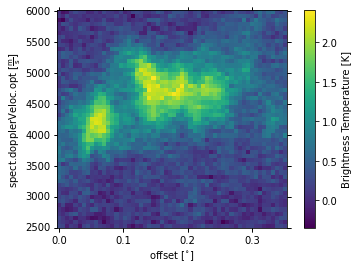

In [7]:
ax = pl.subplot(111, projection=wcs.WCS(pvdiagram.header))
im = ax.imshow(pvdiagram.data)
cb = pl.colorbar(mappable=im)
# we could specify the colorbar units like this:
# cb.set_label(cube.unit)
# but the 'BUNIT' keyword is not set for these data, so we don't know the unit.  We instead manually specify:
cb.set_label("Brightness Temperature [K]")

Changing units to the more commonly used km/s and more readable arcminutes can be done with [wcsaxes tools](https://docs.astropy.org/en/stable/visualization/wcsaxes/controlling_axes.html):

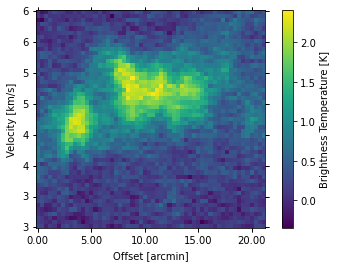

In [8]:
ww = wcs.WCS(pvdiagram.header)

ax = pl.subplot(111, projection=ww)
im = ax.imshow(pvdiagram.data)
cb = pl.colorbar(mappable=im)
cb.set_label("Brightness Temperature [K]")

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcmin)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)

ax.set_ylabel("Velocity [km/s]")
ax.set_xlabel("Offset [arcmin]")

We can put all this together:

In [9]:
# we will use the peak intensity for future display
# the warning here can be ignored because the cube is small,
# but we don't silence it because it's a legit warning when dealing with big cubes
mx = cube.max(axis=0).value

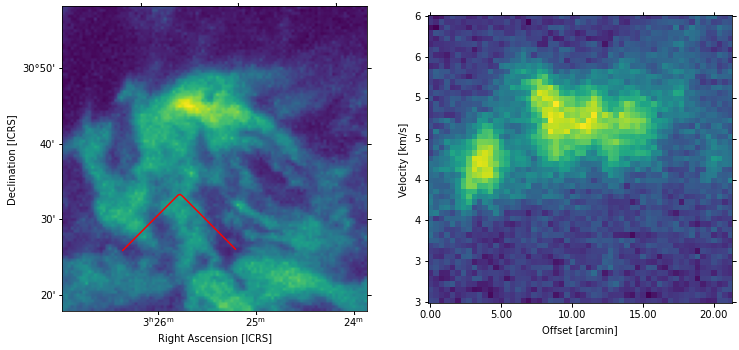

In [10]:
pl.figure(figsize=(12,6))
ax = pl.subplot(121, projection=cube.wcs.celestial)
ax.imshow(mx)
path.show_on_axis(ax, spacing=1, color='r')

ww = wcs.WCS(pvdiagram.header)
ax.set_xlabel(f"Right Ascension [{cube.wcs.wcs.radesys}]")
ax.set_ylabel(f"Declination [{cube.wcs.wcs.radesys}]")

ax = pl.subplot(122, projection=ww)
im = ax.imshow(pvdiagram.data)

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcmin)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)

ax.set_ylabel("Velocity [km/s]")
ax.set_xlabel("Offset [arcmin]")

# PV Extraction from Sky Coordinates

We can also make paths by supplying coordinates defined in an `astropy.coordinates.SkyCoord` to `pvextractor.Path`.

In [11]:
from astropy.coordinates import SkyCoord

In [12]:
skypath = Path(SkyCoord([3.4, 3.43, 3.42]*u.h, [30.5, 30.75, 30.5]*u.deg, frame='fk5'))

We can plot again; the coordinates will be automatically determined

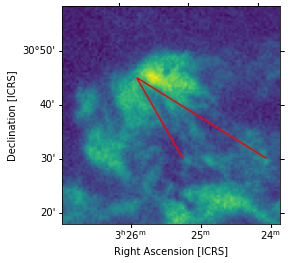

In [13]:
ax = pl.subplot(111, projection=cube.wcs.celestial)
ax.imshow(cube[25].value)
skypath.show_on_axis(ax, spacing=1, color='r')
ax.set_xlabel(f"Right Ascension [{cube.wcs.wcs.radesys}]")
ax.set_ylabel(f"Declination [{cube.wcs.wcs.radesys}]")

In [14]:
pvdiagram2 = extract_pv_slice(cube=cube, path=skypath)
pvdiagram2

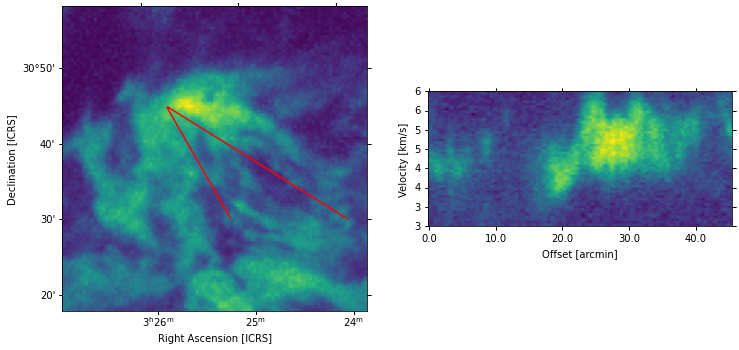

In [15]:
pl.figure(figsize=(12,6))
ax = pl.subplot(121, projection=cube.wcs.celestial)
ax.imshow(mx)
skypath.show_on_axis(ax, spacing=1, color='r')

ww = wcs.WCS(pvdiagram2.header)
ax.set_xlabel(f"Right Ascension [{cube.wcs.wcs.radesys}]")
ax.set_ylabel(f"Declination [{cube.wcs.wcs.radesys}]")

ax = pl.subplot(122, projection=ww)
im = ax.imshow(pvdiagram2.data)

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcmin)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)

ax.set_ylabel("Velocity [km/s]")
ax.set_xlabel("Offset [arcmin]")

We can also change the aspect ratio of the PV diagram.  The `figsize` parameter controls the figure size, which has some effect, and the `ax.set_aspect` command controls the aspect ratio of the individually displayed pixels

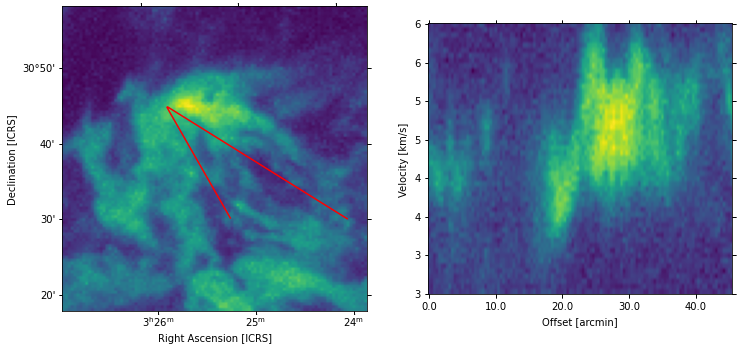

In [16]:
pl.figure(figsize=(12,6))
ax = pl.subplot(121, projection=cube.wcs.celestial)
ax.imshow(mx)
skypath.show_on_axis(ax, spacing=1, color='r')

ww = wcs.WCS(pvdiagram2.header)
ax.set_xlabel(f"Right Ascension [{cube.wcs.wcs.radesys}]")
ax.set_ylabel(f"Declination [{cube.wcs.wcs.radesys}]")


ax = pl.subplot(122, projection=ww)
im = ax.imshow(pvdiagram2.data)
ax.set_aspect(2)

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcmin)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)

ax.set_ylabel("Velocity [km/s]")
ax.set_xlabel("Offset [arcmin]")

## PV Extraction with Spatial Averaging

`pvextractor.Path` allows you to specify a `width` to average over, which specifies a spatial range around the path to average over.

In other words, it turns our path into a series of consecutive rectangular regions.

In [17]:
skypath2 = Path(SkyCoord([3.4, 3.429, 3.42]*u.h, [30.5, 30.75, 30.5]*u.deg, frame='fk5'), width=2*u.arcmin)

In [18]:
pvdiagram3 = extract_pv_slice(cube=cube, path=skypath2)

We can plot this path as a set of patches to show where we averaged.  The default spacing is 1 pixel,so we plot 1-pixel chunks.

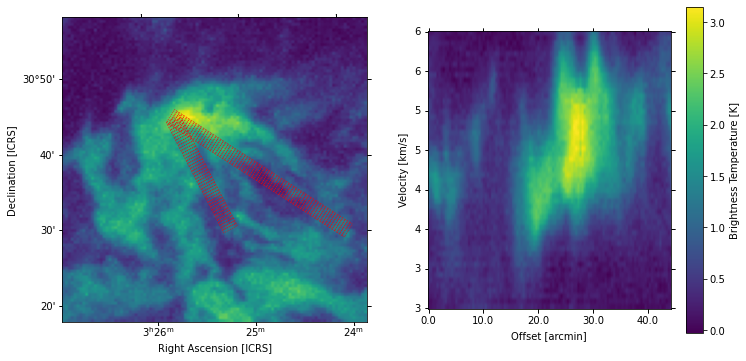

In [19]:
pl.figure(figsize=(12,6))
ax = pl.subplot(121, projection=cube.wcs.celestial)
ax.imshow(mx)

skypath2.show_on_axis(ax, spacing=1,
                      edgecolor='r', linestyle=':',
                      linewidth=0.75)

ww = wcs.WCS(pvdiagram3.header)
ax.set_xlabel(f"Right Ascension [{cube.wcs.wcs.radesys}]")
ax.set_ylabel(f"Declination [{cube.wcs.wcs.radesys}]")

ax = pl.subplot(122, projection=ww)
im = ax.imshow(pvdiagram3.data)
ax.set_aspect(2.5)

cb = pl.colorbar(mappable=im)
cb.set_label("Brightness Temperature [K]")

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcmin)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)


ax.set_ylabel("Velocity [km/s]")
ax.set_xlabel("Offset [arcmin]")

We can also have more widely spaced chunks.

Note that the spacing given to `extract_pv_slice` affects the shape of the output PV diagram, so we also change the aspect ratio:

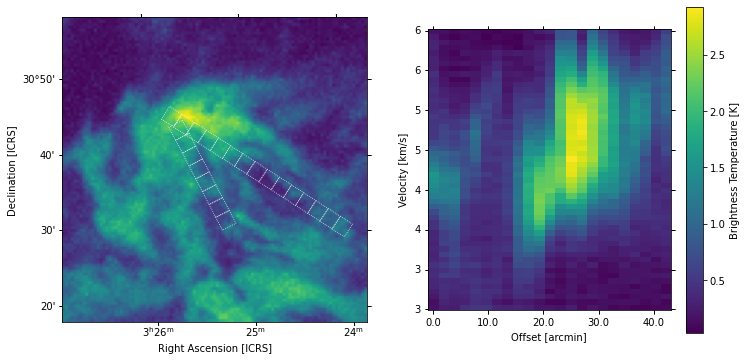

In [20]:
pvdiagram4 = extract_pv_slice(cube=cube, path=skypath2, spacing=5)

fig = pl.figure(figsize=(12,6))
ax = pl.subplot(121, projection=cube.wcs.celestial)
ax.imshow(mx)
skypath2.show_on_axis(ax, spacing=5,
                      edgecolor='w', linestyle=':',
                      linewidth=0.75)

ww = wcs.WCS(pvdiagram4.header)
ax.set_xlabel(f"Right Ascension [{cube.wcs.wcs.radesys}]")
ax.set_ylabel(f"Declination [{cube.wcs.wcs.radesys}]")

ax = pl.subplot(122, projection=ww)
im = ax.imshow(pvdiagram4.data)
cb = pl.colorbar(mappable=im)
cb.set_label("Brightness Temperature [K]")
ax.set_aspect(0.5)

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcmin)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)

ax.set_ylabel("Velocity [km/s]")
ax.set_xlabel("Offset [arcmin]")

## Saving

Finally, we can save the extracted PV diagram as a FITS file:

In [21]:
pvdiagram.writeto("saved_pvdiagram.fits", overwrite=True)

We can also save the figure as a png or pdf:

In [22]:
fig.savefig("saved_pvdiagram.png", bbox_inches='tight')
fig.savefig("saved_pvdiagram.pdf", bbox_inches='tight')